# Raw Data Processing

In [1]:
import os
import glob
import pathlib
import numpy as np
import pandas as pd
from numba import jit
import joblib
from joblib import Parallel, delayed
from rich.progress import track

from typing import Dict, List

import sys
sys.path.append("../src")

import config

from utils.common import timer
from utils.common import load_pickle, dump_pickle, save_cache
from utils.feature import FeatureStore


import matplotlib.pyplot as plt
%matplotlib inline

## Extract data each data_type from txt file

In [2]:
src_dir = pathlib.Path("../data/raw/train/")
filepaths = [
    path_filepath 
    for site_filepath in src_dir.glob("*") 
    for floor_filepath in site_filepath.glob("*") 
    for path_filepath in floor_filepath.glob("*")
]

In [3]:
filepath = filepaths[100]

site_id = filepath.parent.parent.name
floor = filepath.parent.name
path_id = filepath.name.split(".")[0]

feature = FeatureStore(
    site_id=site_id, 
    floor=floor, 
    path_id=path_id, 
    input_path="../data/raw/"
)
feature.load_all_data()

In [5]:
feature.save()

In [6]:
# attributes of site info
[c for c in dir(feature.site_info) if c[0]!="_"]

['draw_polygon',
 'features',
 'floor',
 'floor_coordinates',
 'get_site_info',
 'input_path',
 'map_type',
 'show_site_image',
 'site_height',
 'site_id',
 'site_width',
 'store_coordinates']

In [7]:
feature.site_info.site_height, feature.site_info.site_width

(130.57778814608847, 173.37152638383503)

In [8]:
feature.site_id, feature.floor, feature.path_id

('5cd56b90e2acfd2d33b5e33f', 'F2', '5d08778dbb84450008f56b2b')

In [9]:
# attributes of feature store
for d_type in feature.df_types:
    print(d_type)
    display(feature[d_type].head())

accelerometer


,timestamp,x,y,z
0,1560835848086,-0.691925,-1.003174,9.167404
1,1560835848106,-1.022324,-1.235413,10.522522
2,1560835848126,-0.581787,-1.228226,11.224014
3,1560835848147,-0.050278,-0.962463,10.896011
4,1560835848167,0.076614,-0.416595,9.224854


accelerometer_uncalibrated


,timestamp,x,y,z
0,1560835848086,-1.022324,-1.235413,10.522522
1,1560835848106,-0.581787,-1.228226,11.224014
2,1560835848126,-0.050278,-0.962463,10.896011
3,1560835848147,0.076614,-0.416595,9.224854
4,1560835848167,-0.021545,0.117310,7.886505


beacon


,timestamp,uuid,major_id,minor_id,tx_power,rssi,distance,mac_addr
0,1560835848045,89cb11b04122cef23388b0da06bd426c1f48a9b5,4bd29af61db57eb8675b56f79c5ff4ae6f81c03a,53bd5780a9fa8a4a48e0cc42e974f4ae15699e8f,-59,-90,23.444276,862ba5c86c7f91ca04d69167aff3e95f68ed23d6
1,1560835848118,d9c573b719a17da4836208fc436f87b5ca1aa877,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,-56,-87,26.976490,06d6fddca2b46fc8e4e2b8f4db15494ec851a4b2
2,1560835848151,89cb11b04122cef23388b0da06bd426c1f48a9b5,4bd29af61db57eb8675b56f79c5ff4ae6f81c03a,67e6fc612cb02e98aa57178d033901c8a5764733,-59,-89,21.518471,f643cf4f29973d048fe3e7affb4df047a0609807
3,1560835848203,89cb11b04122cef23388b0da06bd426c1f48a9b5,4bd29af61db57eb8675b56f79c5ff4ae6f81c03a,630afdd1beda6cf46d6453132ef1855488358042,-59,-85,15.128523,815f779cc7325751c44667652830581560a2b3ec
4,1560835848223,89cb11b04122cef23388b0da06bd426c1f48a9b5,4bd29af61db57eb8675b56f79c5ff4ae6f81c03a,b8de63cc8ba97f6faeb0e21d50c6c5826a975c3c,-59,-66,2.246586,9ed08adc70a1e217d77d4ac08d47d6b8ee08e8f9


gyroscope


,timestamp,x,y,z
0,1560835848086,-0.358002,-0.003403,0.138855
1,1560835848106,-0.347885,-0.261734,0.192108
2,1560835848126,-0.162537,-0.436981,0.192642
3,1560835848147,0.095276,-0.435379,0.135651
4,1560835848167,0.151199,-0.313400,0.089844


gyroscope_uncalibrated


,timestamp,x,y,z
0,1560835848086,-0.200272,0.126236,0.112915
1,1560835848106,-0.358459,-0.004257,0.140625
2,1560835848126,-0.348343,-0.262589,0.193878
3,1560835848147,-0.162994,-0.437836,0.194412
4,1560835848167,0.094818,-0.436234,0.137421


magnetic_field


,timestamp,x,y,z
0,1560835848086,-9.12,24.119999,-30.599998
1,1560835848106,-8.82,24.119999,-30.599998
2,1560835848126,-8.76,24.119999,-30.660000
3,1560835848147,-8.46,24.119999,-30.900000
4,1560835848167,-8.40,24.060000,-31.140000


magnetic_field_uncalibrated


,timestamp,x,y,z
0,1560835848086,5.46,39.719997,-169.13998
1,1560835848106,5.76,39.719997,-169.13998
2,1560835848126,5.82,39.719997,-169.20000
3,1560835848147,6.12,39.719997,-169.43999
4,1560835848167,6.18,39.660000,-169.68000


rotation_vector


,timestamp,x,y,z
0,1560835848086,-0.041212,0.049484,-0.252773
1,1560835848106,-0.044584,0.060187,-0.230687
2,1560835848126,-0.047448,0.037496,-0.229790
3,1560835848147,-0.043253,0.008915,-0.168683
4,1560835848167,-0.022116,0.000009,-0.148521


waypoint


,timestamp,x,y
0,1560835847928,79.092990,50.953800
1,1560835860289,81.993440,59.807358
2,1560835867812,79.387955,60.209465
3,1560835878812,76.830475,51.483547
4,1560835884854,74.003296,49.312233


wifi


,timestamp,ssid,bssid,rssi,frequency,last_seen_timestamp
0,1560835848715,90a13d9926e0f11cb22ac9bb4d245a64ed87411c,42c187b2d0163f729407036091b37eb51a7f2b29,-72,5825,1560835830214
1,1560835848715,90a13d9926e0f11cb22ac9bb4d245a64ed87411c,92e9be2bce60e4d35c95329927cc594044e15717,-84,5745,1560835848028
2,1560835848715,90a13d9926e0f11cb22ac9bb4d245a64ed87411c,e4aeea2070b8e610de3fe65e1f21c90b94828a62,-81,5785,1560835848087
3,1560835848715,90a13d9926e0f11cb22ac9bb4d245a64ed87411c,63eb39d4a6bcd69ab05f9cbfb94a5ea1bb23b6d2,-80,5745,1560835848028
4,1560835848715,90a13d9926e0f11cb22ac9bb4d245a64ed87411c,51cdf8a4665fc3ff28336a0c907d5c7fdbe35001,-81,5765,1560835848051


---

## Create map for label encode

In [10]:
src_dir = pathlib.Path("../data/raw/train/")
filepaths = [
    path_filepath 
    for site_filepath in src_dir.glob("*") 
    for floor_filepath in site_filepath.glob("*") 
    for path_filepath in floor_filepath.glob("*")
]

### site for build

In [11]:
def create_site_map():
    def get_site_id_from_feature_store(filepath):
        path_id = filepath.name.split(".")[0]

        feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
        return feature.site_id
    
    site_ids = Parallel(n_jobs=-1)(delayed(get_site_id_from_feature_store)(filepath) for filepath in track(filepaths))
    unique_site_ids = np.unique(site_ids)
    siteId_map = {site_id: i + 1 for i, site_id in enumerate(unique_site_ids)}
    return siteId_map

In [12]:
%%time
siteId_map = create_site_map()

Output()

In [1]:
dump_pickle("./tmp/map_site_ids.pkl", siteId_map)

NameError: name 'dump_pickle' is not defined

### bssid of wifi

In [ ]:
def get_bssid_from_feature_store(filepath):
    path_id = filepath.name.split(".")[0]
    
    feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
    uniques = feature.wifi.bssid.unique()
    if len(uniques) > 0:
        return uniques
    else:
        return np.array([])

In [ ]:
%%time
bssid = Parallel(n_jobs=-1)(delayed(get_bssid_from_feature_store)(filepath) for filepath in track(filepaths))

bssid = np.concatenate(bssid, axis=0)
unique_bsid = np.unique(bssid)

bssid_map = {_bssid: i + 1 for i, _bssid in enumerate(bssid)}
dump_pickle("./tmp/map_bssid.pkl", bssid_map)

### uuid of beacon

In [ ]:
def get_uuid_from_feature_store(filepath):
    path_id = filepath.name.split(".")[0]
    
    feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
    uniques = feature.beacon.uuid.unique()
    if len(uniques) > 0:
        return uniques
    else:
        return np.array([])

In [ ]:
%%time
uuid = Parallel(n_jobs=-1)(delayed(get_uuid_from_feature_store)(filepath) for filepath in track(filepaths))

uuid = np.concatenate(uuid, axis=0)
unique_uuid = np.unique(uuid)

uuid_map = {_uuid: i + 1 for i, _uuid in enumerate(unique_uuid)}
dump_pickle("./tmp/uuid_map.pkl", uuid_map)

---

## Simple feature engineering

In [ ]:
src_dir = pathlib.Path("../data/raw/train/")
filepaths = [
    path_filepath 
    for site_filepath in src_dir.glob("*") 
    for floor_filepath in site_filepath.glob("*") 
    for path_filepath in floor_filepath.glob("*")
]

### Create waypoint

In [9]:
%%time
def create_waypoint(filepaths: List):
    def get_waypoint_from_featureStore(filepath):
        path_id = filepath.name.split(".")[0]

        feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
        wp = feature['waypoint']
        wp['site'] = feature.site_id
        wp['floor'] = feature.n_floor
        wp['path'] = feature.path_id
        if len(wp) > 0:
            return wp
        else:
            return pd.DataFrame([])

    waypoint = Parallel(n_jobs=-1)(delayed(get_waypoint_from_featureStore)(filepath) for filepath in track(filepaths))
    waypoint = pd.concat(waypoint, axis=0).reset_index(drop=True)
    waypoint = waypoint.sort_values(by=['path', 'timestamp']).reset_index(drop=True)
    return waypoint

waypoint = create_waypoint(filepaths)

Output()

CPU times: user 1min 27s, sys: 4.32 s, total: 1min 32s
Wall time: 4min 16s


In [10]:
dump_pickle('./tmp/train_waypoint.pkl', waypoint)

Dump pickle to ./tmp/train_waypoint.pkl


In [11]:
waypoint.head()

,timestamp,x,y,site,floor,path
0,1558318437984,59.747032,244.61037,5cd969ba39e2fc0b4afe6fae,0,5ce215bc2d50640008bf22e2
1,1558318450619,55.360070,256.03390,5cd969ba39e2fc0b4afe6fae,0,5ce215bc2d50640008bf22e2
2,1558318459913,49.936070,254.65387,5cd969ba39e2fc0b4afe6fae,0,5ce215bc2d50640008bf22e2
3,1558318468827,44.060840,252.69990,5cd969ba39e2fc0b4afe6fae,0,5ce215bc2d50640008bf22e2
4,1558318550185,47.224000,245.42503,5cd969ba39e2fc0b4afe6fae,0,5ce215be915519000851776a


### Build

In [12]:
%%time
def create_build(filepaths: List):
    def get_waypoint_from_featureStore(filepath):
        path_id = filepath.name.split(".")[0]
        feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
        return site_map[feature.site_id], feature.site_info.site_height, feature.site_info.site_width
    
    site_map = load_pickle("./tmp/map_site_ids.pkl", verbose=False)
    resutls = Parallel(n_jobs=-1)(delayed(get_waypoint_from_featureStore)(filepath) for filepath in track(filepaths))
    return resutls

results = create_build(filepaths)

site_id, site_height, site_width = zip(*results)

FileNotFoundError: [Errno 2] No such file or directory: './tmp/map_site_ids.pkl'

In [ ]:
site_id = np.array(site_id, dtype='int32')
site_height = np.array(site_height, dtype='float32')
site_width = np.array(site_width, dtype='float32')

In [ ]:
site_id

### Wifi 

In [22]:
%%time
def create_wifi():
    def get_wifi_feature(path_id, gdf):
        seq_len = 100
        bssid = []
        rssi = []
        freq = []

        feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
        wifi = feature.wifi.copy()
        wifi["bssid"] = wifi["bssid"].map(bssid_map)

        min_idx = gdf.index.min()
        max_idx = gdf.index.max()

        for i, row in gdf.iterrows():
            ts_pre_wp = gdf.loc[i - 1, "timestamp"] if i > min_idx else None
            ts_current_wp = gdf.loc[i, "timestamp"]
            ts_post_wp = gdf.loc[i + 1, "timestamp"] if (i + 1) < max_idx else None

            _wifi = wifi.copy()
            # NOTE: ターゲットとなるwaypointとその前後のwaypointの間にあるデータを取得する。
            ts_wifi = _wifi["timestamp"].values
            pre_flag = (
                np.ones(len(ts_wifi)).astype(bool)
                if ts_pre_wp == None
                else (ts_pre_wp < ts_wifi)
            )
            psot_flag = (
                np.ones(len(ts_wifi)).astype(bool)
                if ts_post_wp == None
                else (ts_wifi < ts_post_wp)
            )
            _wifi = _wifi[pre_flag & psot_flag]

            _wifi = _wifi.sort_values(by="rssi", ascending=False)
            _wifi = _wifi.head(seq_len)
            
            _bssid = np.zeros(seq_len)
            _rssi = np.tile(-999, seq_len)
            _freq = np.tile(-999, seq_len)
            
            _bssid[:len(_wifi)] = _wifi["bssid"].astype("int32").to_numpy()
            _rssi[:len(_wifi)] = _wifi["rssi"].astype("float32").to_numpy()
            _freq[:len(_wifi)] = _wifi["frequency"].astype("float32").to_numpy()
            
            bssid.append(_bssid)
            rssi.append(_rssi)
            freq.append(_freq)

        return bssid, rssi, freq

    waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)
    bssid_map = load_pickle("../data/label_encode/map_bssid.pkl", verbose=False)
    results = Parallel(n_jobs=-1)(
        delayed(get_wifi_feature)(path_id, gdf)
        for path_id, gdf in track(waypoint.head(5000).groupby("path"))
    )
    return results

results = create_wifi()

Output()

In [ ]:
bssid, rssi, freq = zip(*results)
bssid = np.concatenate(bssid, axis=0)
rssi = np.concatenate(rssi, axis=0)
freq = np.concatenate(freq, axis=0)

In [ ]:
waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)

In [ ]:
feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)

In [ ]:
waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)
bssid_map = load_pickle("../data/label_encode/map_bssid.pkl", verbose=False)

for path, gdf in waypoint.groupby('path'):
    feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
    wifi = feature.wifi.copy()
    wifi["bssid"] = wifi["bssid"].map(bssid_map)

    min_idx = gdf.index.min()
    max_idx = gdf.index.max()

    print(min_idx)
    print(max_idx)

    break

### Beacon

In [46]:
waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)

In [164]:
%%time
def create_beacon():
    def get_beacon_feature(path_id, gdf):
        seq_len = 20
        uuid = []
        tx_power = []
        rssi = []

        feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
        data = feature.beacon.copy()
        data["uuid"] = data["uuid"].map(uuid_map)

        min_idx = gdf.index.min()
        max_idx = gdf.index.max()

        for i, row in gdf.iterrows():
            ts_pre_wp = gdf.loc[i - 1, "timestamp"] if i > min_idx else None
            ts_current_wp = gdf.loc[i, "timestamp"]
            ts_post_wp = gdf.loc[i + 1, "timestamp"] if (i + 1) < max_idx else None
            
            _data = data.copy()
            # NOTE: ターゲットとなるwaypointとその前後のwaypointの間にあるデータを取得する。
            ts_data = _data["timestamp"].values
            pre_flag = (
                np.ones(len(ts_data)).astype(bool)
                if ts_pre_wp == None
                else (ts_pre_wp < ts_data)
            )
            psot_flag = (
                np.ones(len(ts_data)).astype(bool)
                if ts_post_wp == None
                else (ts_data < ts_post_wp)
            )
            
            _data = _data[pre_flag & psot_flag]
            _data = _data.sort_values(by="rssi", ascending=False)
            _data = _data.head(seq_len)
            
            _uuid = np.zeros(seq_len)
            _tx_power = np.tile(-999, seq_len)
            _rssi = np.tile(-999, seq_len)
            
            _uuid[:len(_data)] = _data["uuid"].fillna(0).astype("int32").to_numpy()
            _tx_power[:len(_data)] = _data["tx_power"].fillna(-999).astype("float32").to_numpy()
            _rssi[:len(_data)] = _data["rssi"].fillna(-999).astype("float32").to_numpy()
            
            uuid.append(_uuid)
            tx_power.append(_tx_power)
            rssi.append(_rssi)

        return uuid, tx_power, rssi

    waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)
    uuid_map = load_pickle("./tmp/uuid_map.pkl", verbose=False)
#     results = Parallel(n_jobs=-1)(
#         delayed(get_beacon_feature)(path_id, gdf)
#         for path_id, gdf in track(waypoint.head(5000).groupby("path"))
#     )

    results = []
    for path_id, gdf in track(waypoint.head(5000).groupby("path")):
        result = get_beacon_feature(path_id, gdf)
        results.append(result)
    return results

waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)
bssid_map = load_pickle("./tmp/map_bssid.pkl", verbose=False)

results = create_beacon()

Output()

CPU times: user 19.5 s, sys: 1.35 s, total: 20.9 s
Wall time: 21.1 s


In [165]:
uuid, tx_power, rssi = zip(*results)
uuid = np.concatenate(uuid, axis=0)
tx_power = np.concatenate(tx_power, axis=0)
rssi = np.concatenate(rssi, axis=0)

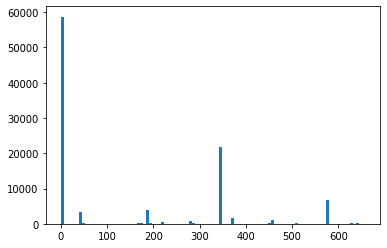

In [168]:
plt.figure()
plt.hist(uuid.ravel(), bins=100)
plt.show()

### Accelerometer

In [28]:
waypoint = load_pickle("./tmp/train_waypoint.pkl", verbose=False)

In [44]:
for path_id, gdf in track(waypoint.head(5000).groupby("path")):
        
    feature = load_pickle(f"../data/working/{path_id}.pkl", verbose=False)
    
    acce = feature.accelerometer
    
    display(acce)
    
    break

Output()

,timestamp,x,y,z
0,1558318438111,0.004593,-0.032867,0.022156
1,1558318438130,0.023514,-0.030273,-0.016800
2,1558318438149,-0.046127,-0.093491,-0.025955
3,1558318438168,-0.013153,-0.037903,-0.013733
4,1558318438188,0.030228,0.008820,-0.009766
...,...,...,...,...
1856,1558318473821,-0.149048,0.004242,0.335678
1857,1558318473840,-0.147827,0.049744,0.313385
1858,1558318473860,-0.109650,0.037842,0.278854
1859,1558318473879,-0.101105,-0.047073,0.215027


### Gyroscope

### Magnetic field

### Rotation vector